### Chapter 02. 머신러닝 프로젝트 처음부터 끝까지 

In [1]:
## packages 
import numpy as np
import pandas as pd 
import matplotlib as mpl 
import matplotlib.pyplot as plt

import sklearn 
import os
import tarfile 
import urllib 

import warnings
warnings.filterwarnings(action="ignore") 

In [2]:
## Califonia housing price 를 가져온다. 
## 외부 깃허브에 tgz로 압축되어 있다. (url로 부터 데이터를 불러와 압축을 푸는 함수를 만들자)

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
## 함수 실행 : 현재 작업공간에 dataset/housing 폴더를 만들고, 압출을 풀어 housing.csv파일을 만든다 
fetch_housing_data()

In [4]:
housing = pd.read_csv('datasets/housing/housing.csv')
print(housing.shape)
housing.head()

(20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
## total_bedrooms에는 20640 - 20433 = 207개의 결측치가 존재 
## ocean_proximity는 유일하게 숫자형이 아닌 변수 

housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
## 변수들의 통계량 확인 

housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


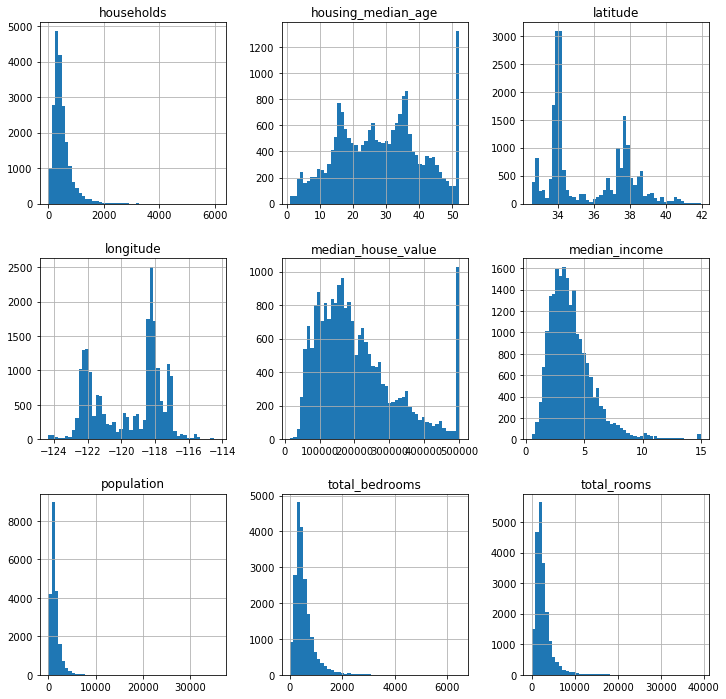

In [8]:
## 히스토그램 

housing.hist(bins = 50, figsize = (12,12))
plt.show()

#### Raw data review 결과 발견된 문제점들 
- 변수들의 scale이 제 각각 
- 다수의 분포가 우편향 
- income의 단위가 USD가 아님 (1만 USD) 
- house_median_age, house_median_value의 경우 매우 큰 극단값들이 존재하는 듯 

In [9]:
## training/test dataset split 
''''
랜덤샘플링의 경우는 아래와 같이 간단하게 할 수 있으나 ...  

from sklearn.model_selection import train_test_split 
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)
'''

"'\n랜덤샘플링의 경우는 아래와 같이 간단하게 할 수 있으나 ...  \n\nfrom sklearn.model_selection import train_test_split \ntrain_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)\n"

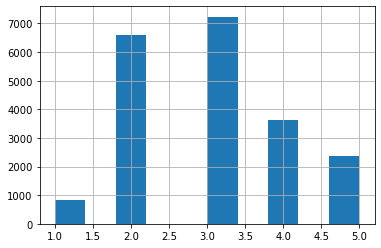

In [10]:
## 여기서는 소득계층을 5개의 카테고리로 구분하여, 층화추출한다. 

housing['income_cat'] = pd.cut(housing['median_income'], 
                              bins = [0. , 1.5, 3.0, 4.5, 6. , np.inf], 
                              labels = [1,2,3,4,5])

housing['income_cat'].hist()

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit 

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in split.split(housing, housing['income_cat']): 
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index] 

In [12]:
print(train_index)
print(test_index)

[17606 18632 14650 ... 13908 11159 15775]
[ 5241 10970 20351 ...  4019 12107  2398]


In [13]:
## 층화추출 결과 확인 (income_cat별 샘플링된 데이터 갯수의 비율 )

print( strat_train_set['income_cat'].value_counts()/len(strat_train_set) )
print( strat_test_set['income_cat'].value_counts()/len(strat_test_set) )

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64
3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64


In [14]:
## 데이터셋 분리 완료, 원 상태로 복구를 위해  income_cat 컬럼 삭제 
## pandas drop에서 axis = 0이면 행을, axis = 1 이면 열을 삭제한다. 

for set_ in (strat_train_set, strat_test_set) : 
    set_.drop('income_cat', axis = 1, inplace = True)

In [19]:
## 데이터 탐색과 시각화 
housing = strat_train_set.copy()
print(housing.shape)
housing.head()

(16512, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


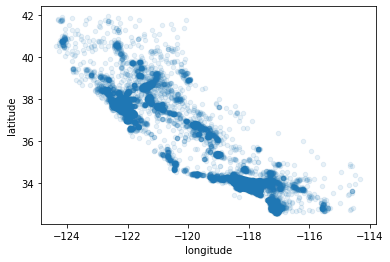

In [22]:
## 위치(위경도)별 주택의 밀집도 시각화 
housing.plot(kind = 'scatter', x = 'longitude' , y = 'latitude', alpha = 0.1)

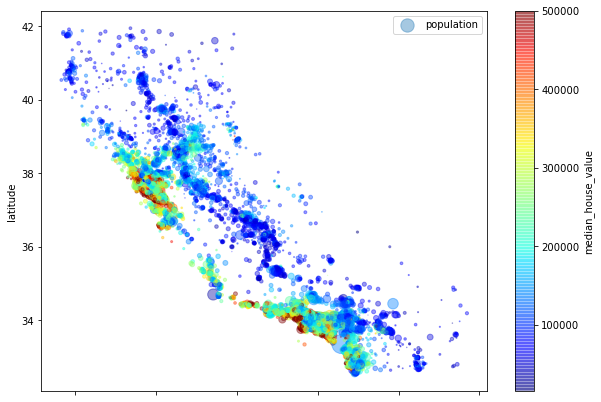

In [34]:
## 인구와 주택가격을 추가 
## cmap = jet는 Low -> High를 Blue -> Red로 표현함  

housing.plot(kind = 'scatter', x = 'longitude' , y = 'latitude', alpha = 0.4, 
             s = housing['population']/100, label = 'population', figsize = (10, 7), 
             c = 'median_house_value', 
             cmap = 'jet', colorbar = True ) 

plt.legend() 

In [37]:
## 주택가격과 다른 변수들간의 correlation 파악 
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C7D41C8748>,
      dtype=object)

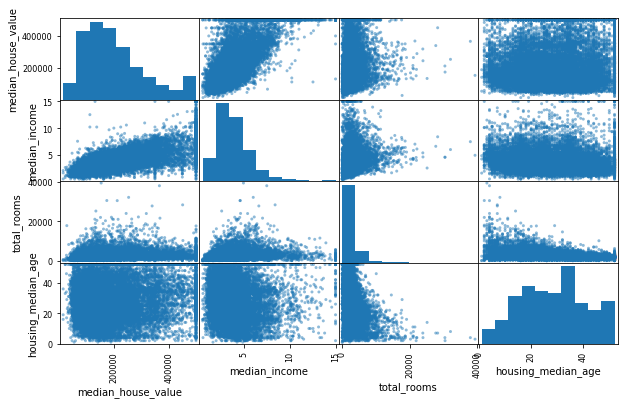

In [38]:
## 전체변수들에 대한 산점도는 11x11 = 121개로 너무 많다. 
## 상관관계 top 3에 대해서만 산점도를 그려보자 (4x4=16개) 
from pandas.plotting import scatter_matrix 

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize = (10, 6))

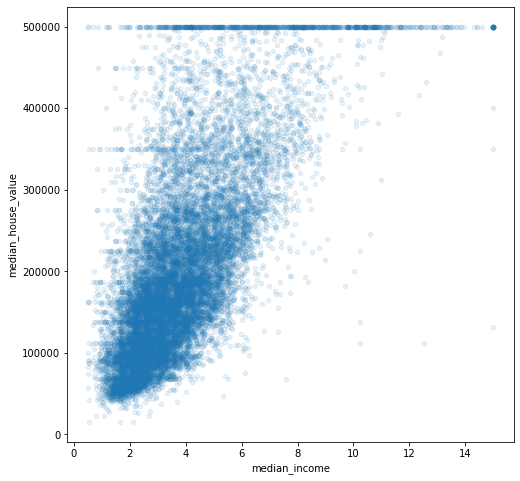

In [47]:
## 집값과 소득만 별도로 표시하기 
housing.plot(kind = 'scatter', y = 'median_house_value', x ='median_income', alpha = 0.1, figsize = (8,8))

- 가격이 약 360,000 UDS, 450,000 UDS 등과, 제한값 50,000 USD 에서 수평선이 보인다. 
- 모형 학습시 이러한 이상한 패턴이 학습되지 않도록 유의해야 한다. 

In [48]:
## 주어진 데이터로 부터 새로운 변수를 생성하고, 이를 주택가격과 상관관계를 파악해 보자 
## 1.가구당 방 갯수, 2.전체 방 갯수 중 침실 비중, 3.가구당 인원 

housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_rooms'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_rooms         -0.259984
Name: median_house_value, dtype: float64

- 방의 갯수가 많으면 가격에 plus, 방 갯수 중 침실의 비중이 적으면 가격에 minus 

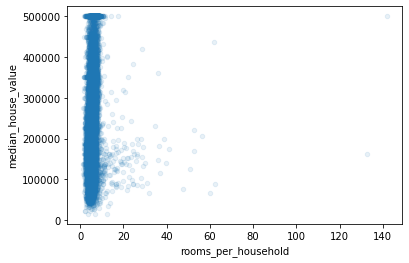

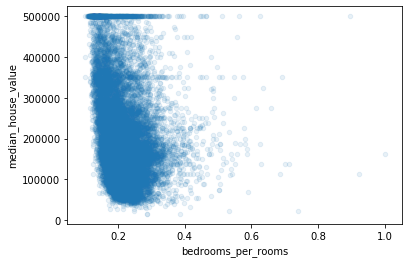

In [52]:
housing.plot(kind = 'scatter', x ='rooms_per_household', y = 'median_house_value', alpha = 0.1)
housing.plot(kind = 'scatter', x ='bedrooms_per_rooms', y = 'median_house_value', alpha = 0.1)

In [55]:
## 데이터 전처리 
## 먼저 training dataset에서 label 컬럼을 분리 

housing = strat_train_set.drop('median_house_value', axis = 1)
housing_labels = strat_train_set['median_house_value'].copy()

#housing.head()
#housing_labels.head()

#### 결측치 제거 방법 
- dropna() : NA값만 제거            ~ housing.dropna(subset = ['total_bedrooms'])
- drop()   : 특정 컬럼을 모두 제거   ~ housing.drop('total_bedrooms', axis = 1)
- fillna() : NA를 특정 값으로 대체   ~ housing['total_bedrooms'].fillna(housing['total_bedrooms'].median(), inplace = True 

In [57]:
## total_bedrooms 컬럼에 NA값이 들어있다. 
## sklearn의 SimpleImputer를 사용해서 중앙값으로 대체하자 

from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(strategy = 'median')

## 숫자형이 아닌 ocean_proximity는 제외되어야 한다. 
housing_num = housing.drop('ocean_proximity', axis = 1)

## imputer를 적용한다. 계산결과(여기서는 median값)는 statistics_ 에 저장된다. 
imputer.fit(housing_num)
imputer.statistics_ 

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [58]:
X = imputer.transform(housing_num)
X

array([[-121.89  ,   37.29  ,   38.    , ...,  710.    ,  339.    ,
           2.7042],
       [-121.93  ,   37.05  ,   14.    , ...,  306.    ,  113.    ,
           6.4214],
       [-117.2   ,   32.77  ,   31.    , ...,  936.    ,  462.    ,
           2.8621],
       ...,
       [-116.4   ,   34.09  ,    9.    , ..., 2098.    ,  765.    ,
           3.2723],
       [-118.01  ,   33.82  ,   31.    , ..., 1356.    ,  356.    ,
           4.0625],
       [-122.45  ,   37.77  ,   52.    , ..., 1269.    ,  639.    ,
           3.575 ]])

In [59]:
housing_tr = pd.DataFrame(X, columns = housing_num.columns, index = housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [73]:
## 수치형 변수들은 준비완료, 문자(범주) 데이터를 전처리 하자

housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [77]:
## sklearn의 OrdinalEncoder를 사용하여 카테고리를 숫자형태로 변환 
## pandas의 factorize() 또는 sklearn의 OrdinalEncoder를 사용하여 단순하게 변환할 수도 있으나, 
## 알고리즘에서 정확하게 반영되도록 하기 위해, one-hot 코딩을 사용한다. (결과는 scipy 희소행렬)

from sklearn.preprocessing import OneHotEncoder 

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [78]:
## SciPy 행렬을 arrary로 변환 
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [79]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]